# Ejemplo de RNN- Series temporales.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#Usamos dataset de producción lechera.

In [3]:
leche = pd.read_csv('produccion-leche.csv',index_col='Month')
leche.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [4]:
leche.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6+ KB


In [5]:
leche.index = pd.to_datetime(leche.index) # creamos un indice para la serie de tiempo

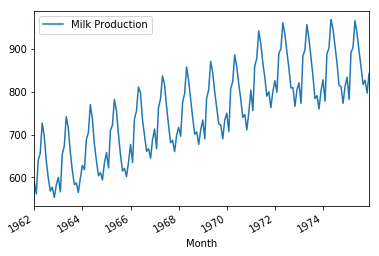

In [42]:
leche.plot()

In [43]:
#dividimos datos de train(primeros 150) y test(ultimos 18)

In [6]:
conjunto_entrenamiento = leche.head(150)
conjunto_pruebas = leche.tail(18)

In [7]:
#normalizar los datos para tensorflow

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
normalizacion = MinMaxScaler()

In [10]:
entrenamiento_normalizado = normalizacion.fit_transform(conjunto_entrenamiento)

In [11]:
pruebas_normalizado = normalizacion.transform(conjunto_pruebas)

In [12]:
pruebas_normalizado

array([[0.85336538],
       [0.75480769],
       [0.62980769],
       [0.62259615],
       [0.52884615],
       [0.625     ],
       [0.67548077],
       [0.55048077],
       [0.81490385],
       [0.84134615],
       [0.99278846],
       [0.92307692],
       [0.82451923],
       [0.73317308],
       [0.63461538],
       [0.65865385],
       [0.58653846],
       [0.69711538]])

In [13]:
#creamos funcion para armar lotes

In [14]:
def lotes(datos_entrenaiento, tamano_lote, pasos):
    comienzo = np.random.randint(0,len(datos_entrenaiento) - pasos)
    lote_y = np.array(datos_entrenaiento[comienzo:comienzo + pasos + 1]).reshape(1,pasos+1)
    return lote_y[:,:-1].reshape(-1,pasos,1),lote_y[:,1:].reshape(-1,pasos,1)

In [16]:
numero_entradas = 1
numero_pasos = 18
numero_neuronas = 120
numero_salidas = 1
tasa_aprendizaje = 0.001
numero_iteraciones_entrenamiento = 1000
tamano_lote = 1

In [19]:
x= tf.placeholder(tf.float32,[None, numero_pasos, numero_entradas])
y = tf.placeholder(tf.float32,[None, numero_pasos, numero_salidas])

In [20]:
#capa de neurona recurrente

In [21]:
capa = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicLSTMCell(num_units=numero_neuronas, activation=tf.nn.relu), output_size=numero_salidas)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [22]:
# salidas de los estados

In [24]:
salidas, estados = tf.nn.dynamic_rnn(capa, x,dtype=tf.float32 )

Instructions for updating:
Colocations handled automatically by placer.


In [48]:
#creamos funcion de costo y optimizador

In [25]:
funcion_error = tf.reduce_mean(tf.square(salidas-y))
optimizador = tf.train.AdamOptimizer(learning_rate=tasa_aprendizaje)
entrenamiento = optimizador.minimize(funcion_error)

In [26]:
#iniciar variables globales

In [27]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [29]:
with tf.Session() as sesion:
    sesion.run(init)
    for iteracion in range(numero_iteraciones_entrenamiento):
        lote_x, lote_y = lotes(entrenamiento_normalizado, tamano_lote, numero_pasos)
        sesion.run(entrenamiento,feed_dict={x:lote_x, y:lote_y})
        if iteracion %100 == 0:
            error = funcion_error.eval(feed_dict={x:lote_x,y:lote_y})
            print(iteracion, "\t Error ", error)
            
        saver.save(sesion, "modelo_series_temporales")

0 	 Error  0.18522052
100 	 Error  0.025180867
200 	 Error  0.015245655
300 	 Error  0.011421506
400 	 Error  0.012586248
500 	 Error  0.009819418
600 	 Error  0.013041256
700 	 Error  0.0075572473
800 	 Error  0.006740347
900 	 Error  0.007995737


In [30]:
#cuando terminan las 5000 iteraciones procedemos a predecir los resultados finales.

In [31]:
with tf.Session() as sesion:
    saver.restore(sesion, "./modelo_series_temporales")
    entrenamiento_seed = list(entrenamiento_normalizado[-18:])
    for iteracion in range(18):
        lote_x = np.array(entrenamiento_seed[-numero_pasos:]).reshape(1,numero_pasos,1)
        prediccion_y = sesion.run(salidas, feed_dict={x:lote_x})
        entrenamiento_seed.append(prediccion_y[0,-1,0])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./modelo_series_temporales


In [33]:
resultados = normalizacion.inverse_transform(np.array(entrenamiento_seed[18:]).reshape(18,1))

In [34]:
resultados

array([[ 937.6015 ],
       [ 902.00195],
       [ 882.85583],
       [ 874.722  ],
       [ 873.9999 ],
       [ 878.90076],
       [ 890.63293],
       [ 912.48956],
       [ 946.54504],
       [ 988.24963],
       [1027.6147 ],
       [1040.5619 ],
       [1023.41785],
       [ 994.75946],
       [ 974.6947 ],
       [ 960.7795 ],
       [ 951.1393 ],
       [ 945.75885]], dtype=float32)

In [36]:
conjunto_pruebas['predicciones']= resultados

C:\Users\sysadmin\AppData\Local\conda\conda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


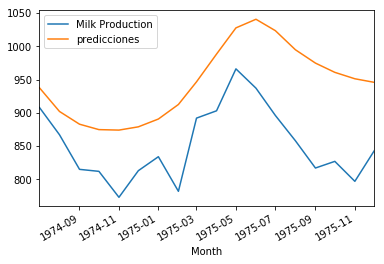

In [37]:
conjunto_pruebas.plot()

In [38]:
conjunto_pruebas

,Milk Production,predicciones
Month,,
1974-07-01 01:00:00,908.0,937.601501
1974-08-01 01:00:00,867.0,902.001953
1974-09-01 01:00:00,815.0,882.855835
1974-10-01 01:00:00,812.0,874.721985
1974-11-01 01:00:00,773.0,873.999878
1974-12-01 01:00:00,813.0,878.900757
1975-01-01 01:00:00,834.0,890.632935
1975-02-01 01:00:00,782.0,912.489563
1975-03-01 01:00:00,892.0,946.545044
